In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

# SVM

In [3]:
from classifiers.datasets.dataloader import ToyBlochSphereLoader
from classifiers.datasets.datascaler import DataMultiScaler, DataScaler
from classifiers.kernel import Kernel
from classifiers.convex.svm import BinarySVM
from classifiers.visualization import Plot_SVM, Plot_Data


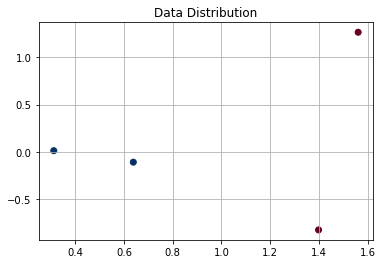

In [4]:
dl = ToyBlochSphereLoader(gap=np.pi/5)
ds = DataScaler('standard')
np.random.seed(30)
X, y = dl(4, 0.1)
kernel = Kernel('SingleQubit')
Plot_Data(X, y).plot()


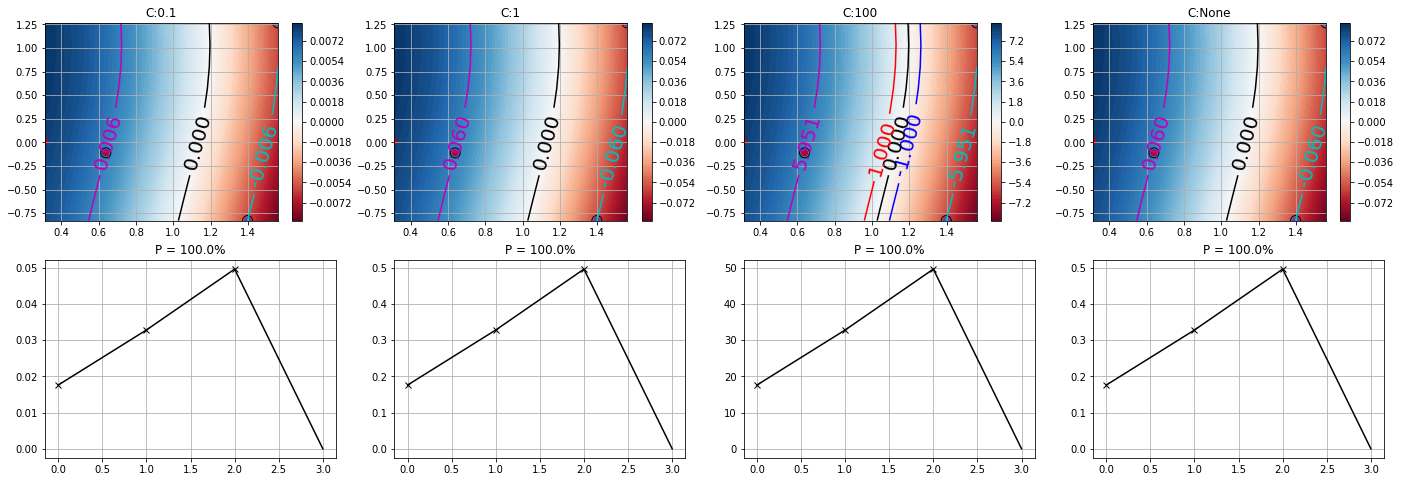

In [5]:
svms = [BinarySVM(kernel, C=C, k=0.1, mutation='REDUCED_QASVM') for C in [0.1, 1, 100, None]]
[svm.fit(X, y) for svm in svms]
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
for n in range(4):
    ax0 = axes[0][n]
    ax1 = axes[1][n]
    plot = Plot_SVM(svms[n])
    plot.plot_boundary(ax=ax0, fig=fig)
    plot.plot('alpha', ax=ax1)
    ax0.set_title(f'C:{svms[n].C}')
    if svms[n].status == 'optimal':
        ax1.set_title(f'P = {100*svms[n].accuracy(X, y)}%')
    else:
        ax1.set_title('Not Optimal')
    

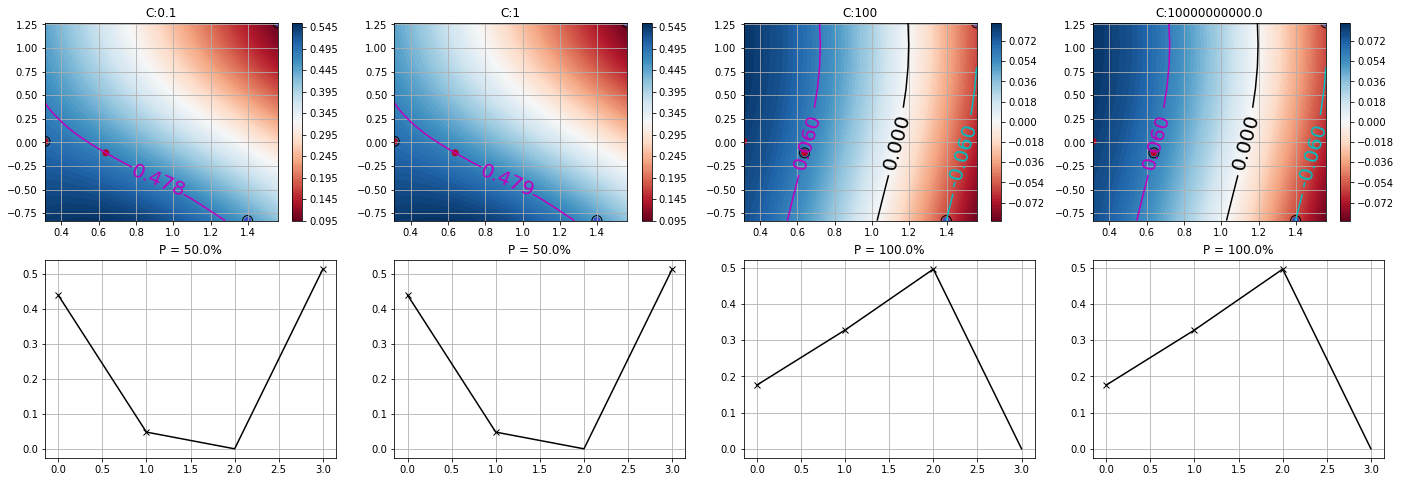

In [6]:
svms = [BinarySVM(kernel, C=C, k=0.1, mutation='REDUCED_primal_QASVM') for C in [0.1, 1, 100, 1e10]]
[svm.fit(X, y) for svm in svms]
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
for n in range(4):
    ax0 = axes[0][n]
    ax1 = axes[1][n]
    plot = Plot_SVM(svms[n])
    plot.plot_boundary(ax=ax0, fig=fig)
    plot.plot('alpha', ax=ax1)
    ax0.set_title(f'C:{svms[n].C}')
    if svms[n].status == 'optimal':
        ax1.set_title(f'P = {100*svms[n].accuracy(X, y)}%')
    else:
        ax1.set_title('Not Optimal')

In [7]:
svm = BinarySVM(kernel, C=None, k=0.1, mutation='REDUCED_QASVM')
svm.fit(X, y)

# QASVM with Noise Model

In [8]:
from classifiers.datasets.dataloader import ToyBlochSphereLoader
from classifiers.datasets.datascaler import DataMultiScaler, DataScaler
from classifiers.quantum.qasvm import QASVM, BlochSphereQASVM, QASVM
from classifiers.visualization import Plot_Log_From_SPSA, Plot_Data
from classifiers.utils import get_optimizer_logger
from qiskit.aqua.components.optimizers import SLSQP, SPSA
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes
from qiskit.aqua.quantum_instance import QuantumInstance
from qiskit.providers.aer import QasmSimulator

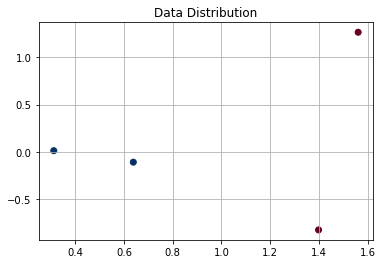

In [9]:
dl = ToyBlochSphereLoader(gap=np.pi/5)
np.random.seed(30)
X, y = dl(4, 0.1)
Plot_Data(X, y).plot()

In [10]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')
provider.backends()

/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_manhattan') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('

In [11]:
from qiskit.test.mock import FakeMontreal as fake
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
backend = QasmSimulator.from_backend(provider.get_backend('ibmq_manhattan'))
#backend = QasmSimulator()

In [12]:
var_form = RealAmplitudes(2, reps=5)
feature_map = TwoLocal(1, ['ry', 'rz'], skip_final_rotation_layer=True, reps=1)
optimizer = SPSA(maxiter=2**13, last_avg=2**8)
logger = get_optimizer_logger(optimizer)

102


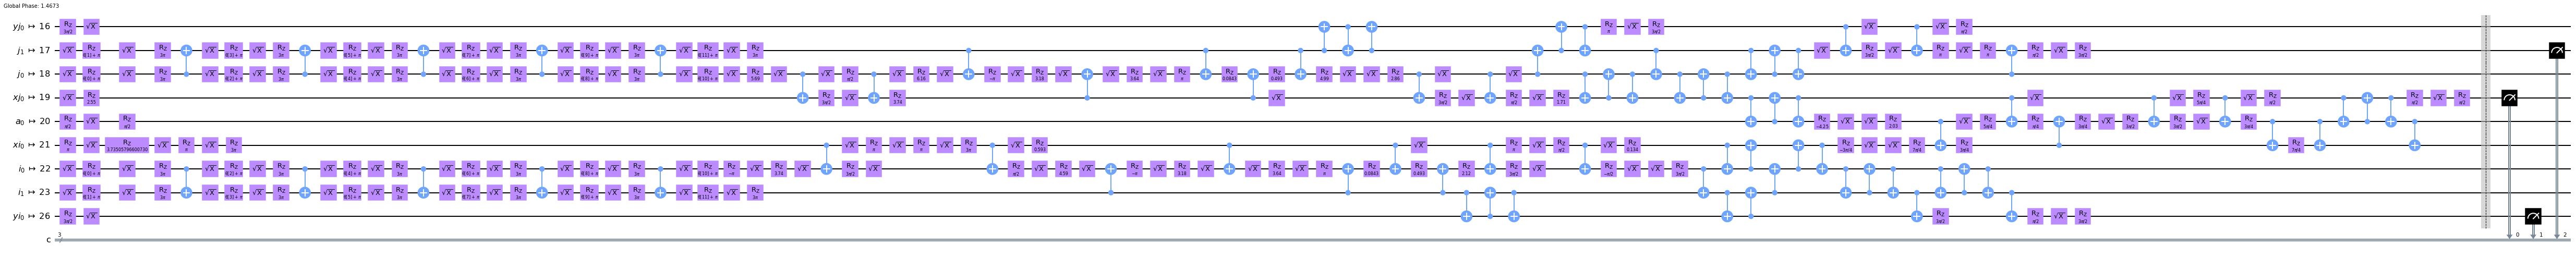

In [13]:
quantum_instance = QuantumInstance(backend=backend, seed_transpiler=10, optimization_level=3, shots=2**13)
qasvm = BlochSphereQASVM(var_form=var_form, optimizer=optimizer, training_data=X, training_label=y, quantum_instance=quantum_instance, C=100, k=0.1).primal
virtual_q = qasvm.second_order_circuit.qubits
'''
qasvm.quantum_instance.compile_config['initial_layout'] = {
    virtual_q[0]:3,
    virtual_q[1]:0,
    virtual_q[2]:4,
    virtual_q[3]:2,
    virtual_q[4]:1,
    virtual_q[5]:9,
    virtual_q[6]:11,
    virtual_q[7]:5,
    virtual_q[8]:8
}'''
qasvm.quantum_instance.compile_config['layout_method'] = 'noise_adaptive'
del qasvm.quantum_instance.qjob_config['wait']
qc = qasvm.quantum_instance.transpile(qasvm.second_order_circuit)[0]
print(qc.depth())
qc.draw('mpl', idle_wires=False, fold=-1)

In [ ]:
qasvm.run()
qasvm.accuracy(X, y)

In [ ]:
import dill
import pathlib
import uuid
dill.dump_session(logger.handlers[-1].baseFilename.split('.')[0]+'.dill')


# End Session

# Restart Session

In [18]:
import dill

import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)
import pathlib

p = pathlib.Path.home()/'QUIC-Projects'/'exp_logs'
#dill.load_session(max(p.glob('*.dill'), key=lambda p: p.stat().st_ctime))
files = sorted(p.glob('*.dill'), key=lambda p: p.stat().st_ctime, reverse=True)
log_files = sorted(p.glob('*.log'), key=lambda p: p.stat().st_ctime, reverse=True)
dill.load_session(files[-2])

In [19]:
qasvm.quantum_instance.backend

QasmSimulator(
backend_name='qasm_simulator')

In [20]:
qasvm.isdual

True

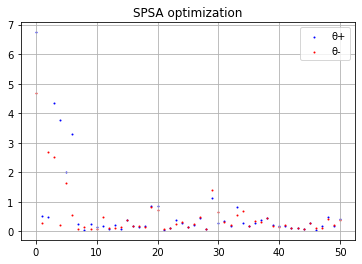

In [25]:
Plot_Log_From_SPSA(log_files[-2]).plot(min_step=0, max_step=50)

In [22]:
qasvm.quantum_instance.run_config.shots = 2**18

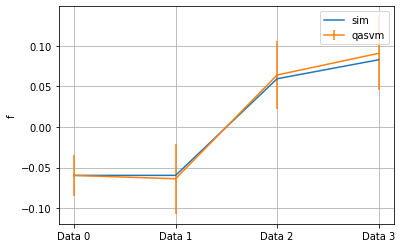

In [23]:
plt.plot(svm.f(X), label='sim')
res = np.array([qasvm.f(X) for _ in range(10)])
plt.errorbar(range(len(res.mean(axis=0))), res.mean(axis=0), yerr=2*res.std(axis=0), label='qasvm')
plt.xticks(range(4), [f'Data {i}' for i in range(4)])
plt.ylabel('f')
plt.legend()
plt.grid()

In [8]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.4',
 'qiskit-aer': '0.7.5',
 'qiskit-ignis': '0.5.2',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.2',
 'qiskit': '0.23.6'}

In [ ]:

from classifiers.utils import clean_exp_logs
clean_exp_logs()